## Holland integral and Vm Rm / B

It works better with sqrt(B) than with B. 

But for the K94 plot (notebook 02), it works better with B. 

In [1]:
# General
import glob
import os.path
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.colors import Normalize
# from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import pandas as pd

# Data treatment
import dask as da
from dask.diagnostics import ProgressBar
import zarr
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from scipy.signal import argrelextrema
from datetime import datetime

# Custom
# import functions as f

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PRMS = {'save_figs':       False,
          'ds_glob_path':    '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
}

### OPEN DATA
dsg = xr.open_dataset(PRMS['ds_glob_path'])
print('Nb of storms: {}'.format(len(dsg.time)))

### Add intensification parameters
dsg2 = xr.open_dataset('/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_17102022_with_extra_params.nc')
dsg['Vmax_dot_smth_IBT'] = xr.DataArray(
    data=np.array(dsg2['Vmax_dot_smth_IBT']),
    coords={'time': dsg.time}
)
dsg['Vmax_dot_IBT'] = xr.DataArray(
    data=np.array(dsg2['Vmax_dot_IBT']),
    coords={'time': dsg.time}
)
dsg['R17_dot_IBT'] = xr.DataArray(
    data=np.array(dsg2['R17_dot_IBT']),
    coords={'time': dsg.time}
)
dsg['R17_dot_smth_IBT'] = xr.DataArray(
    data=np.array(dsg2['R17_dot_smth_IBT']),
    coords={'time': dsg.time}
)

### Kinetic energy
K1_SAR = dsg['Vmax_1D'] * (dsg['Vmax_dot_smth_IBT'] * 3600) * ((dsg['R17_1D'] * 1000) ** 2)
K2_SAR = dsg['R17_1D'] * 1000 * (dsg['R17_dot_smth_IBT'] * 1000 * 3600) * (dsg['Vmax_1D'] ** 2)
K1_IBT = dsg['Vmax_IBT'] * (dsg['Vmax_dot_smth_IBT'] * 3600) * ((dsg['R34_IBT']) ** 2) 
K2_IBT = dsg['R34_IBT'] * (dsg['R17_dot_smth_IBT'] * 1000 * 3600) * (dsg['Vmax_IBT'] ** 2)

dsg['dKdt_SAR'] = K1_SAR + K2_SAR
dsg['dKdt_IBT'] = K1_IBT + K2_IBT

Nb of storms: 335


In [3]:
### FILTER
dsg = dsg.where(dsg.distance_to_coast > dsg.R17_1D * 1000, drop=True)
dsg = dsg.where(abs(dsg.lat_center) < 30, drop=True)
# dsg = dsg.where(dsg.lon_center < -50, drop=True) # Keep only USA best-track agencies
# dsg = dsg.where(dsg.distance_to_coast > 200000, drop=True)
print('Nb of storms: {}'.format(len(dsg.time)))

Nb of storms: 195


In [4]:
### FUNCTIONS
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def holland_profile(r, lat, pn, pc, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor  = abs(coriolis(lat))
    rho   = 1.15
    # B     = (Vmax ** 2) * rho * np.e / (pn - pc)
    B     = ((Vmax - Vmin) ** 2) * rho * np.e / (pn - pc)
    A     = Rmax ** B
    
    r     = r.astype(np.float) + 0.001 # To avoid dividing by zero
    V     = r * 0.
    V     = Vmin + np.sqrt(A * B * (pn - pc) * np.exp((-1) * A / (r ** B)) / (rho * r ** B) + (r ** 2 * fcor ** 2) / 4) - (r * fcor / 2)
    return V

In [5]:
lat  = float(dsg.lat_center.mean(skipna=True))
pn   = float(dsg.pn_hol.mean(skipna=True))
pc   = float(dsg.pc_hol.mean(skipna=True))
Vmin = float(dsg.Vmin_hol.mean(skipna=True))
Rmax = float(dsg.Rmax_hol.mean(skipna=True))
Vmax = float(dsg.Vmax_hol.mean(skipna=True))

B    = float(dsg.B_hol.mean(skipna=True))

print('lat = {:.1f}, pn = {:.0f}, pc = {:.0f}, Vmin = {:.0f}, Rmax = {:.0f}, Vmax = {:.0f}, B = {:.0f}'.format(lat, pn, pc, Vmin, Rmax, Vmax, B))

lat = 12.3, pn = 100922, pc = 99221, Vmin = 9, Rmax = 42039, Vmax = 36, B = 2


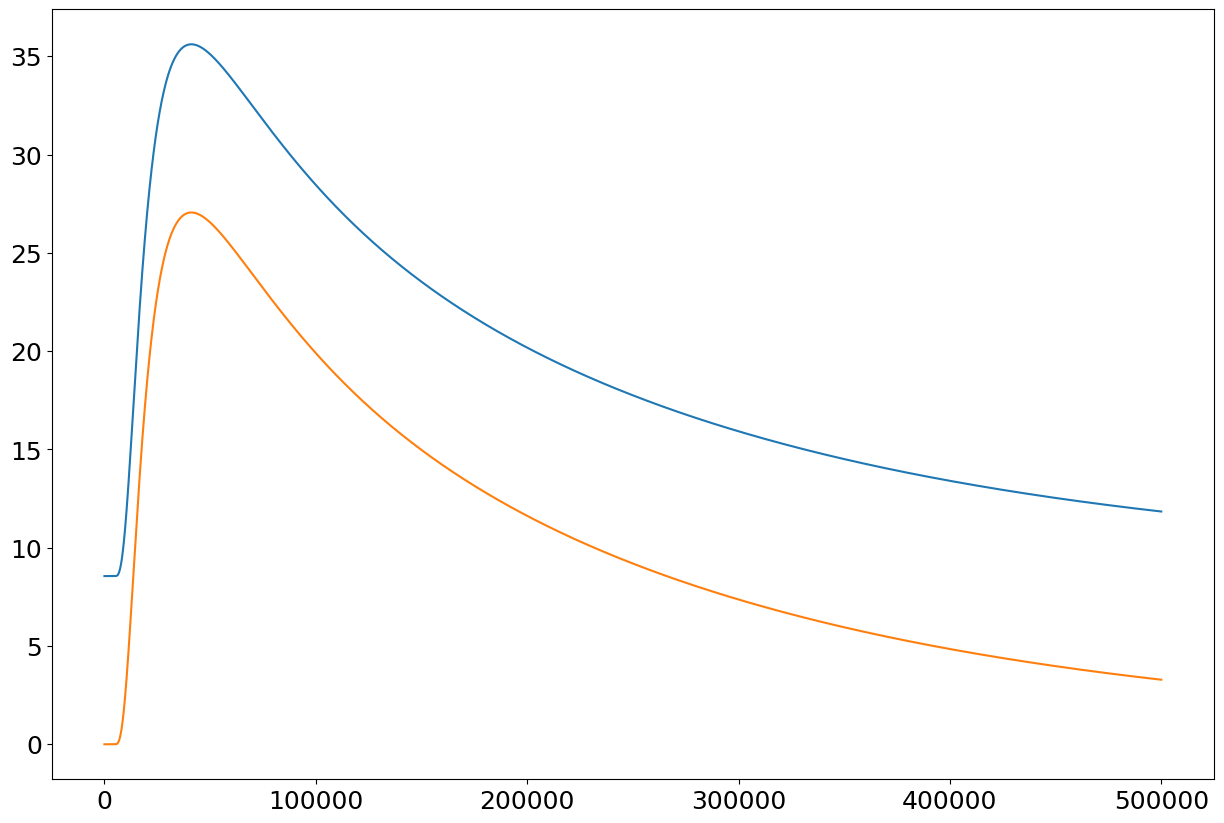

In [6]:
rs = np.linspace(0, 500000, 50001)
Vh = holland_profile(rs, lat, pn, pc, Vmin, Rmax, Vmax)

plt.plot(rs, Vh)
plt.plot(rs, Vh - Vmin)

100%|████████████████████████████████████████| 195/195 [00:01<00:00, 121.19it/s]


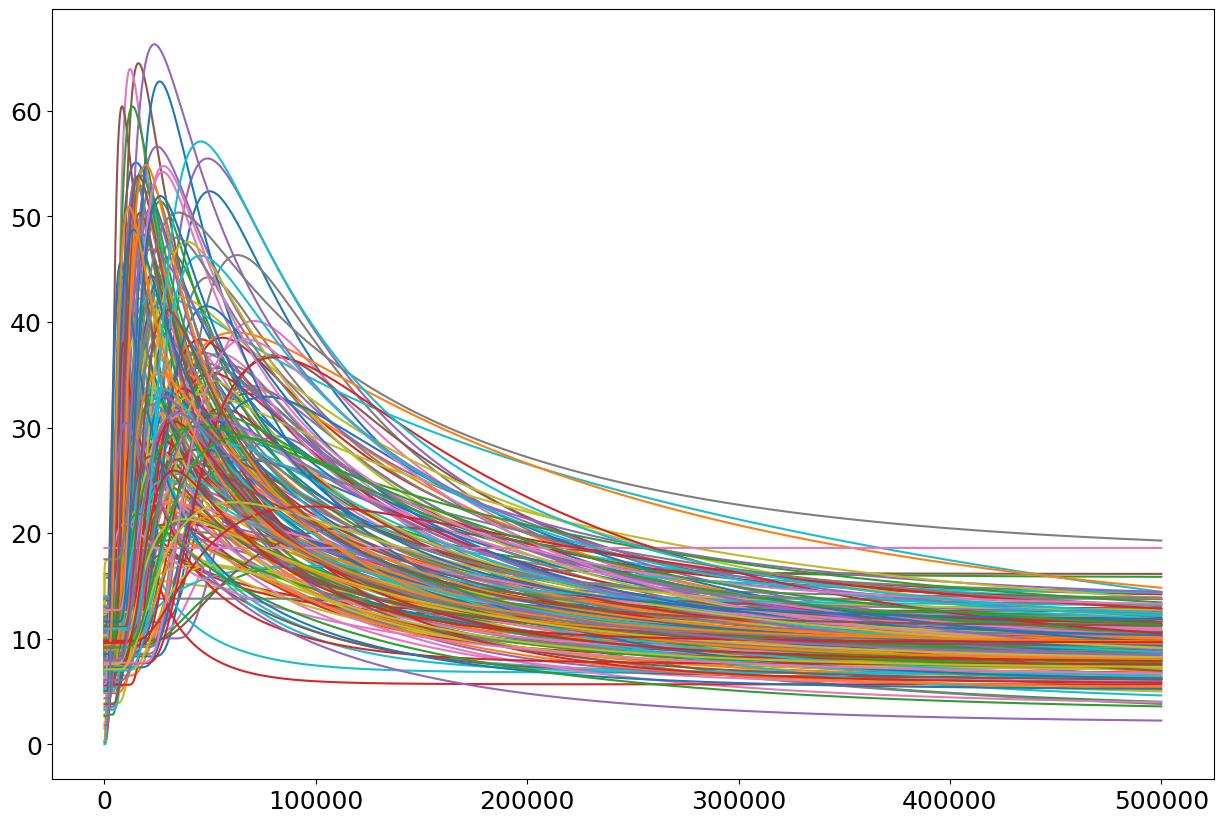

In [10]:
TPZ = []
PRM = []

for t in tqdm(np.arange(len(dsg.time))):
    ds = dsg.isel(time=t)
    
    lat  = float(ds.lat_center)
    pn   = float(ds.pn_hol)
    pc   = float(ds.pc_hol)
    Vmin = float(ds.Vmin_hol)
    Rmax = float(ds.Rmax_hol)
    Vmax = float(ds.Vmax_hol)
    B    = float(ds.B_hol)
    
    Vh = holland_profile(rs, lat, pn, pc, Vmin, Rmax, Vmax)
    plt.plot(rs, Vh)
    # Vh = holland_profile(rs, lat, pn, pc, Vmin, Rmax, Vmax) - Vmin
    
    TPZ.append(np.trapz(Vh, rs))
    # PRM.append(Vmax * Rmax / (2 * B ** 0.5))
    # PRM.append(ds.R17_1D * 1000 * Vmax / B + Vmax * Rmax / B)
    # PRM.append(ds.R17_1D * 1000 * Vmax / B + Vmax * Rmax / B + Vmin * ds.R17_1D * 1000)
    PRM.append(ds.R17_1D * 1000 * Vmax / (2 * B))
    

(195,)
(192,)


Text(0, 0.5, 'Parameters')

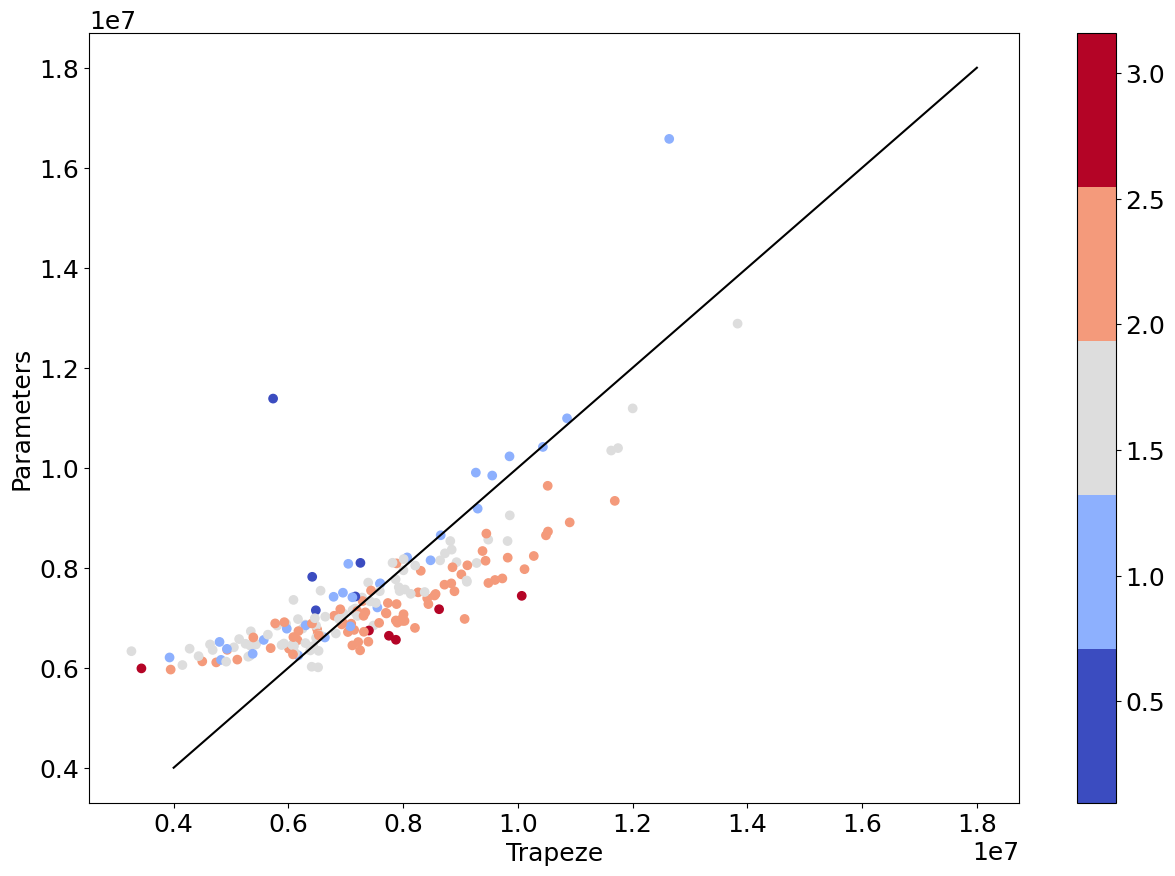

In [11]:
TPZ = np.array(TPZ)
PRM = np.array(PRM)

dff = TPZ - PRM
print(np.shape(dff))
msk = dff < 0
dff = dff[~msk]
print(np.shape(dff))
b = np.mean(dff)

plt.scatter(TPZ[~msk], PRM[~msk] + b, c=np.array(dsg.B_hol)[~msk], cmap=cm.get_cmap('coolwarm', 5))
plt.plot([0.4e7, 1.8e7], [0.4e7, 1.8e7], c='k')
plt.colorbar()
plt.xlabel('Trapeze');plt.ylabel('Parameters')

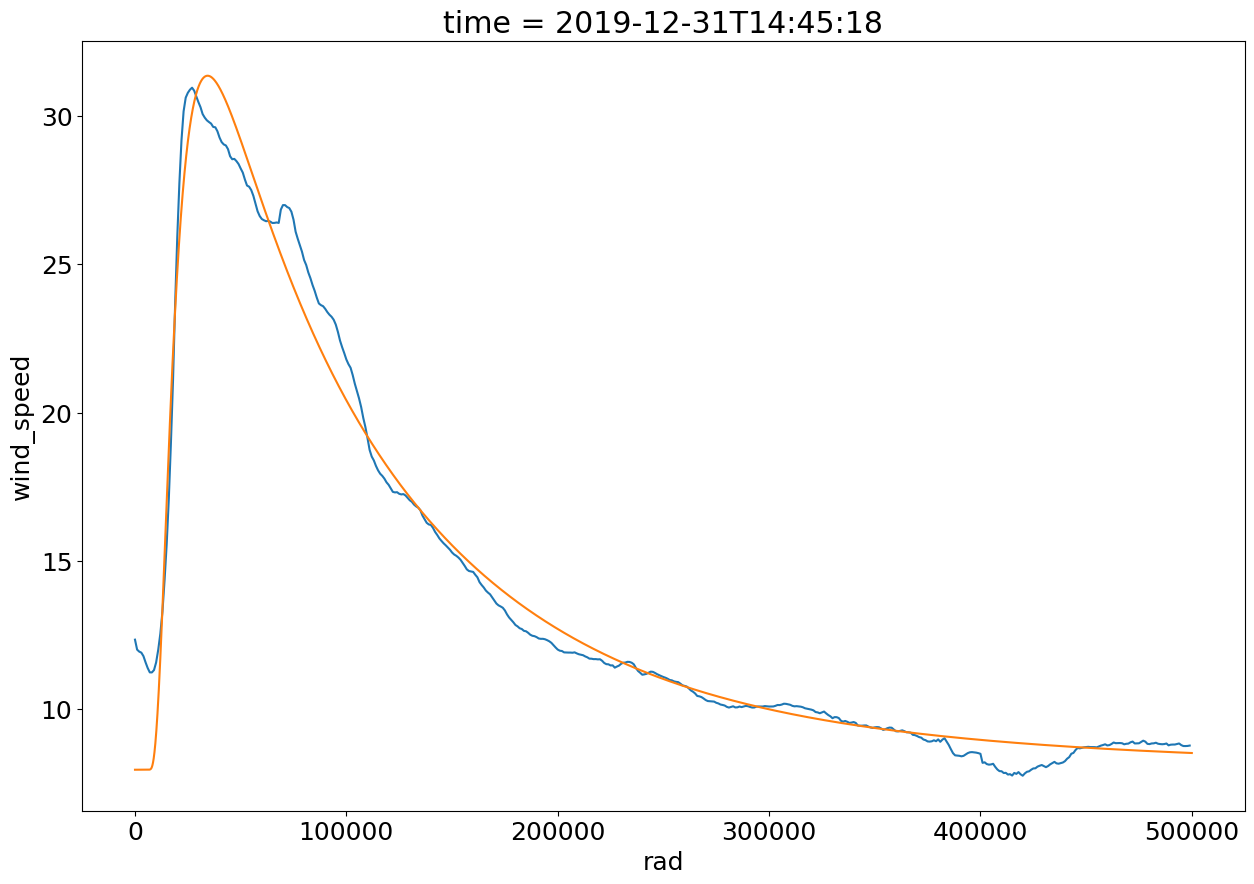

In [12]:
ds = dsg.where(dsg.sat_file == 's1a-ew-owi-cm-20191231t144416-20191231t144620-000003-03813D_sw.nc', drop=True)
ds.wind_speed.mean(dim='theta').plot()

lat  = float(ds.lat_center)
pn   = float(ds.pn_hol)
pc   = float(ds.pc_hol)
Vmin = float(ds.Vmin_hol)
Rmax = float(ds.Rmax_hol)
Vmax = float(ds.Vmax_hol)
B    = float(ds.B_hol)

Vh = holland_profile(rs, lat, pn, pc, Vmin, Rmax, Vmax)
plt.plot(rs, Vh);plt.show()